# Step 1: Install and Import Required Libraries

In [ ]:
# Step 1.1: Install yfinance
!pip install yfinance --quiet

# Step 1.2: Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


yfinance is the Python library that lets you download stock market data (like from Yahoo Finance).

--quiet is just an optional flag to suppress the output from pip.

#Step 2: Load Apple (AAPL) Stock Price Data

In [ ]:
# Re-download the stock data with a wider date range
df = yf.download('AAPL', start='2010-01-01', end='2024-12-31')

# Check the full DataFrame
print("Data shape:", df.shape)
df.head()



[*********************100%***********************]  1 of 1 completed

Data shape: (3773, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446623,6.382908,6.414465,493729600
2010-01-05,6.443018,6.479384,6.409056,6.449630,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370885,6.371487,6.283128,6.320394,447610800


In [ ]:
# Step 1: Print the first few rows of the DataFrame
print(df.head())

# Step 2: Print column names to verify
print("Column names:", df.columns)


Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.431896  6.446623  6.382908  6.414465  493729600
2010-01-05  6.443018  6.479384  6.409056  6.449630  601904800
2010-01-06  6.340531  6.468562  6.333919  6.443016  552160000
2010-01-07  6.328810  6.371488  6.282827  6.363974  477131200
2010-01-08  6.370885  6.371487  6.283128  6.320394  447610800
Column names: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


#Step 3.1: Extract the 'Close' Prices

In [ ]:
# Flatten the MultiIndex columns
df.columns = df.columns.get_level_values(0)

# Now extract the 'Close' column
data = df[['Close']]
dataset = data.values

# Check the shape and first 5 values
print("Shape of data:", dataset.shape)
print("First 5 closing prices:\n", dataset[:5])


Shape of data: (3773, 1)
First 5 closing prices:
 [[6.43189621]
 [6.44301796]
 [6.34053087]
 [6.32881021]
 [6.37088537]]


#Step 3.1: Normalize the Data

LSTM models perform better when the input data is scaled (normalized) to a range like [0, 1].


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler to scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the dataset
scaled_data = scaler.fit_transform(dataset)

# Check first 5 scaled values
print("First 5 scaled values:\n", scaled_data[:5])


First 5 scaled values:
 [[0.00261253]
 [0.00265655]
 [0.00225086]
 [0.00220447]
 [0.00237102]]


#Step 3.3: Create Sequences for LSTM

In [ ]:
'''LSTM works on sequences.So we'll use a sliding window approach:

For every 60 past days' closing prices, we’ll predict the 61st day's price.

This gives us:

X_train → shape (samples, 60, 1)

y_train → shape (samples, 1)

'''

"LSTM works on sequences.So we'll use a sliding window approach:\n\nFor every 60 past days' closing prices, we’ll predict the 61st day's price.\n\nThis gives us:\n\nX_train → shape (samples, 60, 1)\n\ny_train → shape (samples, 1)\n\n"

In [ ]:
# Training data length (we'll use 80% of the data for training)
training_data_len = int(len(scaled_data) * 0.8)

# Split the scaled data
train_data = scaled_data[:training_data_len]

# Create empty lists
X_train = []
y_train = []

# Use past 60 days to predict the next day
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])   # 60 values
    y_train.append(train_data[i, 0])        # 61st value

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Output the shape
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (2958, 60, 1)
y_train shape: (2958,)


X_train: 2,958 samples, each with 60 timesteps and 1 feature (closing price)

y_train: 2,958 target values



#Step 4: Build the LSTM Model

We’ll use Keras to build a sequential LSTM model with:

2 LSTM layers

1 Dense layer for output

Dropout to prevent overfitting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Step 5: Train the LSTM Model

batch_size=32: Small batches improve gradient updates

epochs=10: Enough to start learning patterns (you can later try 30+ for better results)

validation_split=0.1: Uses 10% of training data to monitor overfitting

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,         # You can increase this later (e.g., 20 or 30)
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.5796e-04 - val_loss: 0.0016
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 1.6090e-04 - val_loss: 0.0011
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 1.2364e-04 - val_loss: 0.0026
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.6017e-04 - val_loss: 7.0430e-04
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 1.4614e-04 - val_loss: 4.6673e-04
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 1.5078e-04 - val_loss: 4.3990e-04
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 1.2749e-04 - val_loss: 4.4672e-04
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 1.1018e-04 - val_loss: 0.0010
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 1.4647e-04 - val_loss: 2.5043e-04
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1.2962e-04 - val_loss: 7.0359e-04
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1.7311e-04 - val_loss: 2.

#Step 6: Plot the Training & Validation Loss

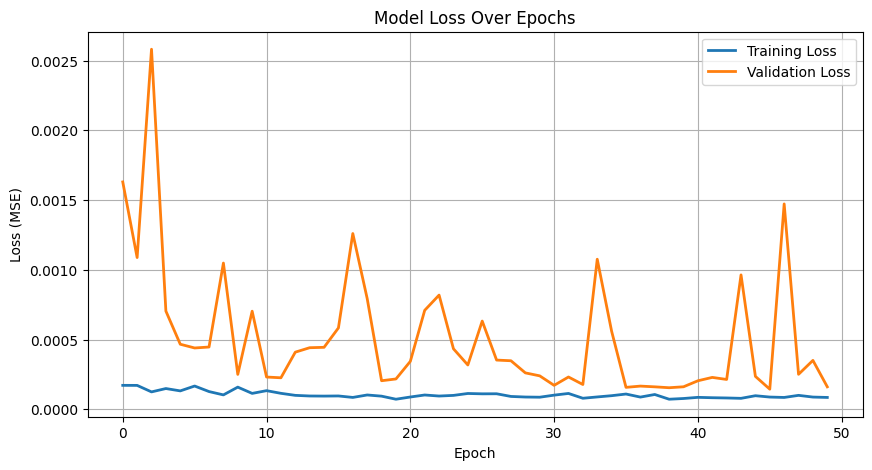

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


 Observations:

Training loss is low and stable (great!)

Validation loss is higher and fluctuates a lot — that suggests:

The model might be overfitting slightly (learning training data too well)

Or the validation subset is noisy/small, causing spikes

This is normal with financial time series data — markets are highly volatile and hard to predict perfectly.



#Step 7: Save the Trained Model

In [ ]:
# Save the model
model.save('stock_price_lstm_model.keras')


#Step 8: Prepare Test Data and Make Predictions

In [ ]:
# Get the testing data (remaining 20%)
test_data = scaled_data[training_data_len - 60:]  # Include 60 days before test set

X_test = []
y_test = dataset[training_data_len:]  # Actual closing prices (unscaled)

# Create X_test sequences
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Predict using the model
predictions = model.predict(X_test)

# Inverse transform to get actual prices (undo MinMaxScaler)
predictions = scaler.inverse_transform(predictions)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


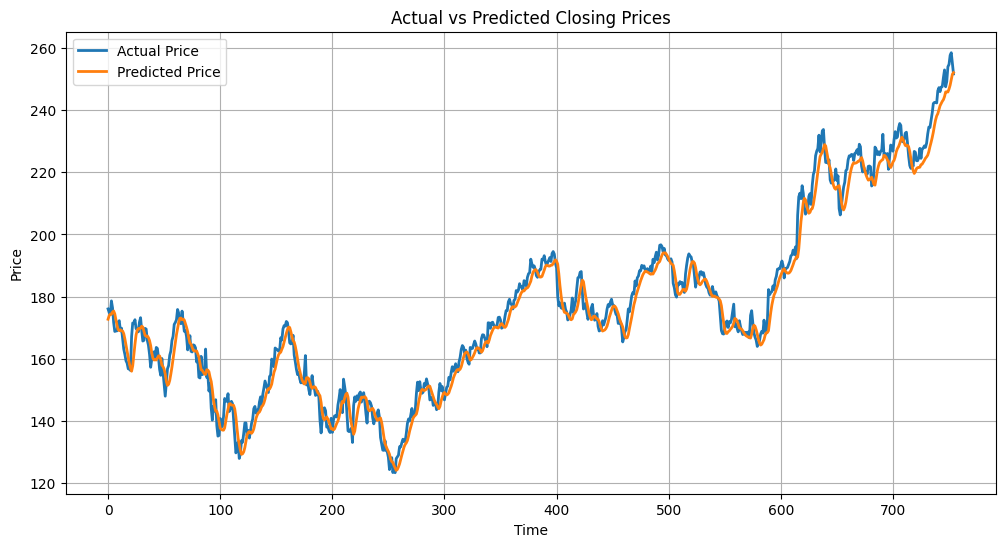

In [ ]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', linewidth=2)
plt.plot(predictions, label='Predicted Price', linewidth=2)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('stock_price_lstm_model.keras')


#Step 9: Evaluate the Model with Metrics

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Root Mean Squared Error (RMSE): 4.363641102570273
Mean Absolute Error (MAE): 3.5131316835517126


#Step 10: Predict the Next Day Price from Recent Data

Take the last 60 closing prices

Scale them

Reshape to fit the model

Predict the next day's price

In [32]:
# Use 'data' if 'closing_price' is not defined
last_60_days = data[-60:].values  # shape: (60, 1)

# Scale it using the previously fitted scaler
last_60_days_scaled = scaler.transform(last_60_days)

# Reshape to (1, 60, 1)
X_input = np.reshape(last_60_days_scaled, (1, 60, 1))

# Predict
predicted_price_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print("📈 Predicted next day closing price: ₹", round(predicted_price[0][0], 2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
📈 Predicted next day closing price: ₹ 251.13


In [33]:
# 🔁 Replace this list with your own 60 past closing prices
my_input_prices = [
    170.23, 171.42, 169.84, 170.30, 172.02, 173.65, 172.80, 171.95,
    170.70, 172.60, 173.10, 172.40, 171.55, 172.35, 173.05, 173.90,
    174.45, 175.10, 176.00, 175.85, 176.30, 177.05, 176.95, 177.40,
    177.95, 178.10, 178.60, 179.05, 178.80, 179.40, 179.95, 180.10,
    180.45, 180.85, 181.10, 181.65, 182.00, 182.55, 183.10, 183.40,
    183.95, 184.10, 184.65, 185.00, 185.45, 185.85, 186.10, 186.65,
    187.00, 187.45, 187.85, 188.10, 188.65, 189.00, 189.45, 189.85,
    190.10, 190.65, 191.00, 191.45
]


In [34]:
custom_input = np.array(my_input_prices).reshape(-1, 1)

# Scale using the same scaler
custom_scaled = scaler.transform(custom_input)

# Reshape to (1, 60, 1) for LSTM
X_custom = np.reshape(custom_scaled, (1, 60, 1))

# Predict
custom_pred_scaled = model.predict(X_custom)
custom_pred = scaler.inverse_transform(custom_pred_scaled)

print("📊 Predicted next day price based on your input: ₹", round(custom_pred[0][0], 2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
📊 Predicted next day price based on your input: ₹ 189.32
